In [3]:
import gym
from gym import envs
env = gym.make('Blackjack-v0')


In [4]:
dir(env)
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

# Задание 1
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [5]:
import numpy as np

debug =  False
results = []
num_iter = 1000000

for i in range(num_iter):
    cur, dealer, space = env.reset()
    
    if debug: print("start", cur, dealer, space)
    
    is_finished = False
    while cur <= 18:
        state, score, is_finished, some =  env.step(1)
        cur = state[0]
        if debug: print("more", cur, score, is_finished, some)
    
    if is_finished:
        results.append(score)
    else:
        state, score, is_finished, some = env.step(0)
        if debug: print("stop", state, score, is_finished, some)  
        assert is_finished == True
        results.append(score)

print(f'средний выигрыш по стратегии {np.mean(np.array(results))}') 

средний выигрыш по стратегии -0.201288


Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [6]:
num_states = 32*11*2
num_actions = 2

def get_code_by_state(state):
    return state[0]*22 + state[1] *2 + (1 if state[2] else 0) 

def get_state_by_code(code):
    is_ace = True if code%2 == 1 else False
    dealer = (int(code/2))%11
    player = int(code/22)
    return (player, dealer, is_ace)

def egreedy_policy(q_values, state, epsilon=0.1):  
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values[state])


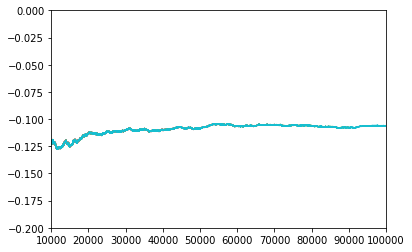

last_avg_reward -0.10605000000000021


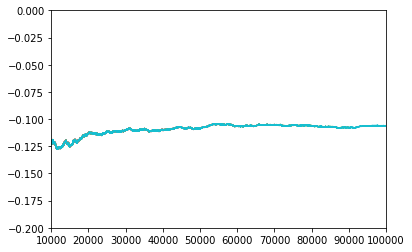

In [7]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, some = env.step(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values
    
avg_rewards, states_counter, q_values = conduct_experiment(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, debug = False, plot = True)


In [8]:
# пройдемся по посещенным состояниям и выведем Q
for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), " assessment ", q_values[i][:], states_counter[i], np.argmax(q_values[i]), round(q_values[i][np.argmax(q_values[i])],2))

(4, 1, False)  assessment  [-0.38295804 -0.35596613] [14. 31.] 1 -0.36
(4, 2, False)  assessment  [ 0.05326763 -0.1519622 ] [25. 23.] 0 0.05
(4, 3, False)  assessment  [-0.03871896 -0.18869002] [14. 33.] 0 -0.04
(4, 4, False)  assessment  [-0.16037265 -0.04342037] [14. 28.] 1 -0.04
(4, 5, False)  assessment  [-0.07654119 -0.04304301] [13. 43.] 1 -0.04
(4, 6, False)  assessment  [-0.09253002 -0.02917949] [ 6. 58.] 1 -0.03
(4, 7, False)  assessment  [-0.18549375 -0.10800385] [ 4. 32.] 1 -0.11
(4, 8, False)  assessment  [-0.18100834 -0.13446235] [ 8. 37.] 1 -0.13
(4, 9, False)  assessment  [-0.20579595 -0.19937214] [15. 24.] 1 -0.2
(4, 10, False)  assessment  [-0.38107194 -0.36185454] [ 18. 161.] 1 -0.36
(5, 1, False)  assessment  [-0.54233885 -0.432329  ] [21. 77.] 1 -0.43
(5, 2, False)  assessment  [-0.0557936  -0.12081429] [24. 64.] 0 -0.06
(5, 3, False)  assessment  [-0.23399319 -0.15431858] [18. 79.] 1 -0.15
(5, 4, False)  assessment  [-0.14247527 -0.03887772] [15. 79.] 1 -0.04
(5, 5

Поподбираем гиперпараметры, но в целом на миллионе итераций максимум вышел на learnnig_rate 0.01 и таким же epsilon, мельче я не дробил. Оставлю тут код для более широкого range

начинаем эксперимент, lr = 0.01 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.0704700000000004
начинаем эксперимент, lr = 0.01 epsilon = 0.04 num_iter = 100000
last_avg_reward -0.0862399999999995
начинаем эксперимент, lr = 0.01 epsilon = 0.06 num_iter = 100000
last_avg_reward -0.09308000000000029
начинаем эксперимент, lr = 0.01 epsilon = 0.08 num_iter = 100000
last_avg_reward -0.09612999999999992
начинаем эксперимент, lr = 0.01 epsilon = 0.1 num_iter = 100000
last_avg_reward -0.10512999999999993
начинаем эксперимент, lr = 0.04 epsilon = 0.02 num_iter = 100000
last_avg_reward -0.08269999999999882
начинаем эксперимент, lr = 0.04 epsilon = 0.04 num_iter = 100000
last_avg_reward -0.08459999999999947
начинаем эксперимент, lr = 0.04 epsilon = 0.06 num_iter = 100000
last_avg_reward -0.08965000000000044
начинаем эксперимент, lr = 0.04 epsilon = 0.08 num_iter = 100000
last_avg_reward -0.0956199999999996
начинаем эксперимент, lr = 0.04 epsilon = 0.1 num_iter = 100000
last_avg_reward -0.105

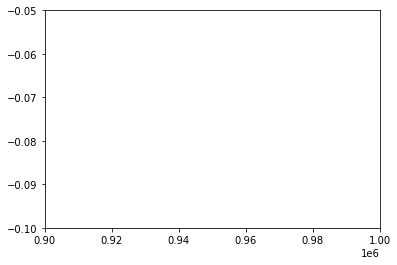

In [9]:
for learning_rate in np.linspace(0.01, 0.1, 4):
    for epsilon in np.linspace(0.02, 0.1, 5):
        avg_rewards, states_counter, q_values = conduct_experiment(learning_rate, epsilon)
        plt.plot(avg_rewards, label = f'lr={learning_rate}, eps = {epsilon}')
        
plt.xlim(90000, 100000)
plt.ylim(-0.1,-0.05)
plt.show()

# Задание 2

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. 

Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. 

Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


Просто добавим в класс метод step_new

In [10]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    # добавим новый метод, так проще всего реализовать
    def step_new(self, action):
        if self.action_space.contains(action):
            return self.step(action)
        else:
            state, reward, done, empty = self.step(1)
            if done:
                return state, reward * 2, done, empty
            else:
                state, reward, done, empty = self.step(0)
                assert done==True
                return state, reward * 2, done, empty

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()


In [11]:
env = BlackjackEnv()
env.reset()

(13, 2, False)

In [12]:
# переопределим число действий
num_actions = 3

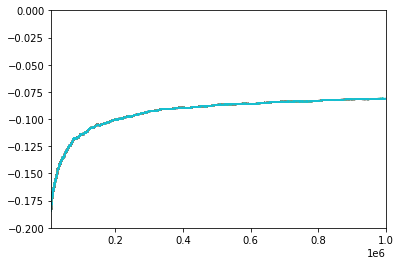

last_avg_reward -0.08122699999999967


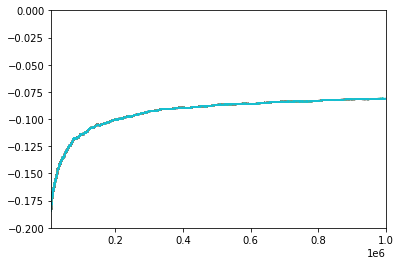

In [13]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, some = env.step_new(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values
    
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.01, epsilon = 0.04, num_iterations = 1000000, debug = False, plot = True)


In [14]:
# пройдемся по посещенным состояниям и выведем Q
for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), " assessment ", q_values[i][:], states_counter[i], np.argmax(q_values[i]), round(q_values[i][np.argmax(q_values[i])],2))

(4, 1, False)  assessment  [-0.42249076 -0.41511415 -0.44506575] [ 83. 316.  36.] 1 -0.42
(4, 2, False)  assessment  [-0.16508916 -0.13048682 -0.19387644] [ 52. 384.  48.] 1 -0.13
(4, 3, False)  assessment  [-0.08084131 -0.06673966 -0.11567556] [ 21. 408.  16.] 1 -0.07
(4, 4, False)  assessment  [-0.05951862 -0.05186359 -0.09888546] [ 37. 367.  15.] 1 -0.05
(4, 5, False)  assessment  [-0.0648767  -0.02401352 -0.059402  ] [ 85. 397.   3.] 1 -0.02
(4, 6, False)  assessment  [-0.06356816  0.00380741 -0.11451061] [ 51. 407.   8.] 1 0.0
(4, 7, False)  assessment  [-0.14778438 -0.08879956 -0.11451428] [ 27. 461.  12.] 1 -0.09
(4, 8, False)  assessment  [-0.17981231 -0.17119878 -0.20662784] [ 43. 379.  21.] 1 -0.17
(4, 9, False)  assessment  [-0.23029693 -0.23032627 -0.24924959] [ 46. 407.  24.] 0 -0.23
(4, 10, False)  assessment  [-0.42111807 -0.33734763 -0.5027183 ] [ 103. 1684.   83.] 1 -0.34
(5, 1, False)  assessment  [-0.50217113 -0.47259302 -0.55204564] [ 96. 746.  39.] 1 -0.47
(5, 2, F


Видно что удваивать иногда имеет смысл только если при сдаче выпаало 10 или 11 очков

Снова у меня получился лучший результат при epsilon = 0.01 для миллиона испытаний, так что ооставлю тут только его

начинаем эксперимент, lr = 0.01 epsilon = 0.01 num_iter = 1000000
last_avg_reward -0.06503800000000094
начинаем эксперимент, lr = 0.02 epsilon = 0.01 num_iter = 1000000
last_avg_reward -0.06646899999999857
начинаем эксперимент, lr = 0.03 epsilon = 0.01 num_iter = 1000000
last_avg_reward -0.06595399999999942
начинаем эксперимент, lr = 0.04 epsilon = 0.01 num_iter = 1000000
last_avg_reward -0.06775799999999878
начинаем эксперимент, lr = 0.05 epsilon = 0.01 num_iter = 1000000
last_avg_reward -0.06605399999999592


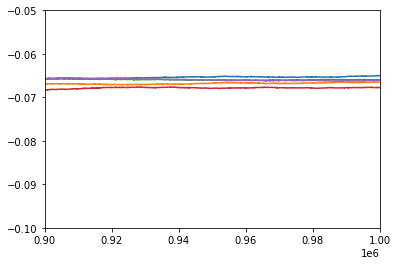

In [15]:
for learning_rate in np.linspace(0.01, 0.05, 5):
    #for epsilon in np.linspace(0.01, 0.03, 3):
        epsilon = 0.01
        avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate, epsilon, 1000000)
        plt.plot(avg_rewards, label = f'lr={learning_rate}, eps = {epsilon}')
        
plt.xlim(900000, 1000000)
plt.ylim(-0.1,-0.05)
plt.show()

# Задание 3

Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [16]:
import gym
from gym import spaces
from gym.utils import seeding
import random
import numpy as np
from collections import Counter


def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10

deck_new = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv_real(gym.Env):
    def __init__(self, debug = False, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.natural = natural
        # Start the first game
        # это индекс карты которая будет сдана следующей
        self.current_indedx = 0
        # поместим колоду внутрь класса
        self.deck = deck_new.copy()
        self.debug = debug
        self.init_deck()
        self.reset()
        if self.debug: print("finish init")

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, self.current_index

    # добавим новый метод т.к. все сформулировано в его методах
    def step_new(self, action):
        if self.action_space.contains(action):
            return self.step(action)
        else:
            state, reward, done, empty = self.step(1)
            if not done:
                state, reward, done, empty = self.step(0)

            return state, reward * 2, done, self.current_index

    def _get_obs(self):
        # out_cards -то что вышло до начала розыгрыша
        out_cards = Counter(self.deck[0:self.current_index - len(self.player) - len(self.dealer)])
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), (self.player, self.dealer, out_cards))

    def reset(self):
        self.check_deck()
        self.dealer = self.draw_hand() 
        self.player = self.draw_hand()
        return self._get_obs()
    
    def init_deck(self):
        self.current_index = 0
        self.deck = deck_new.copy()
        random.shuffle(self.deck)
        if self.debug: print(self.deck)


    def check_deck(self):
    # если карт мало и мы закончили - достаем колоду
        if 52 - self.current_index < 15:
            self.init_deck()    

    def draw_card(self):
        card = self.deck[self.current_index]
        self.current_index += 1
        return card

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]


Сначала просто помоделируем игры, чтобы убедиться, что все запрогано верно

In [17]:
debug =  True
env = BlackjackEnv_real(debug)
env.init_deck()


results = []
num_iter = 10

for i in range(num_iter):
    cur, dealer, space, played_cards = env.reset()
    
    if debug: print("start", cur, dealer, space)
    
    is_finished = False
    while cur <= 18:
        state, reward, is_finished, index =  env.step(1)
        cur = state[0]
        if debug: print("more", cur, reward, is_finished, index)
    
    if is_finished:
        if debug: print("stop", state, reward, is_finished, index)  
        results.append(reward)
    else:
        state, reward, is_finished, index = env.step(0)
        if debug: print("stop", state, reward, is_finished, index)  
        assert is_finished == True
        results.append(reward)
print(np.mean(np.array(results)))  

[5, 10, 6, 3, 1, 10, 6, 10, 10, 8, 7, 5, 10, 6, 10, 8, 10, 10, 7, 3, 2, 5, 10, 7, 4, 5, 6, 9, 4, 3, 10, 2, 10, 2, 3, 9, 8, 7, 10, 9, 1, 10, 1, 10, 4, 10, 2, 4, 10, 9, 8, 1]
finish init
[5, 7, 9, 8, 9, 2, 10, 3, 6, 8, 10, 3, 2, 10, 10, 9, 10, 5, 1, 10, 9, 2, 1, 3, 6, 10, 10, 1, 4, 10, 2, 7, 6, 4, 1, 10, 10, 6, 5, 10, 8, 8, 10, 7, 10, 3, 4, 10, 7, 4, 5, 10]
start 17 5 False
more 26 -1.0 True 5
stop (26, 5, False, ([9, 8, 9], [5, 7], Counter())) -1.0 True 5
start 9 2 False
more 17 0.0 False 10
more 27 -1.0 True 11
stop (27, 2, False, ([3, 6, 8, 10], [2, 10], Counter({9: 2, 5: 1, 7: 1, 8: 1}))) -1.0 True 11
start 20 3 False
stop (20, 3, False, ([10, 10], [3, 2, 9, 10], Counter({9: 2, 8: 2, 10: 2, 5: 1, 7: 1, 2: 1, 3: 1, 6: 1}))) 1.0 True 17
start 19 5 False
stop (19, 5, False, ([10, 9], [5, 1, 2], Counter({10: 5, 9: 3, 8: 2, 2: 2, 3: 2, 5: 1, 7: 1, 6: 1}))) 1.0 True 22
start 16 1 False
more 26 -1.0 True 27
stop (26, 1, False, ([6, 10, 10], [1, 3], Counter({10: 6, 9: 4, 2: 3, 5: 2, 8: 2, 3:

Тест на предыдущей задаче

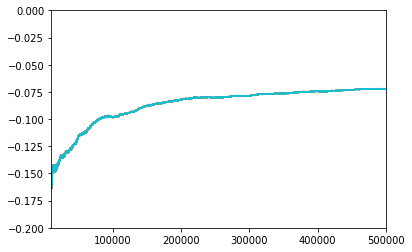

last_avg_reward -0.07215199999999956


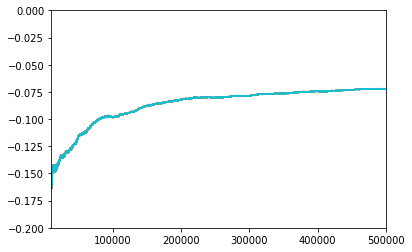

In [18]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

num_states = 32*11*2
num_actions = 3


def get_code_by_state(state):
    state_dims = [32 ,11, 2]
    states = [state[0], state[1], (1 if state[2] else 0)]
    
    state_code = states[0]
    for i in range(1, len(states)):
        state_code = state_code * state_dims[i] + states[i]
    return state_code 


def get_state_by_code(code):
    state_dims = [32 ,11, 2]
    result = []

    for i in range(len(state_dims)-1, -1, -1):
        result.append(code%state_dims[i])
        code = int(code/state_dims[i])
    result.reverse()
    return tuple(result)


def egreedy_policy(q_values, state, epsilon=0.1):  
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(q_values[state])


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, index = env.step_new(action)
            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%10000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(10000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values


debug = False
env = BlackjackEnv_real(debug)
env.init_deck()
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.02, epsilon = 0.02, num_iterations = 500000, debug = debug, plot = True)

+- сошлось

Попробуем сделать как "замечательной книге Стэнфорда Уонга", также сгруппируем по числу карт до начала игры:
[15, 23] [24, 34] [35, 52] по картам [, -7.5] [-7.5, -4.5] [-4.5, -1.5] [-1.5, 1.5] [1.5, 4.5] [4.5, 7.5] [7.5 , +]

In [19]:
def cards_score(card):
    if card in [2, 7]: 
        return 0.5
    elif card in [3, 4, 6]: 
        return 1.
    elif card == 5:
        return 1.5
    elif card == 8:
        return 0.
    elif card == 9:
        return -0.5
    elif card in [10, 1]:
        return -1

def map_card_state(sum_cards):
    mult = np.sign(sum_cards)
    state = int((abs(sum_cards) + 1)/3) 
    state = 3 if state > 3 else state
    return int(state * mult + 3)

   
def get_initial_pos_state(size):
    if size > 23:
        return 0
    elif size > 34:
        return 1
    else:
        return 2
    
# получаем состояние по числу оставшихся карт в колоде и 
def get_composite_state(cards):
    score = 0
    size = 0
    for k in cards.keys():
        score += cards_score(k) * cards[k]
        size += cards[k]
    card_state = map_card_state(score) # 0 to 7
    size_state = get_initial_pos_state(size) # 0 to 3
    return size_state, card_state

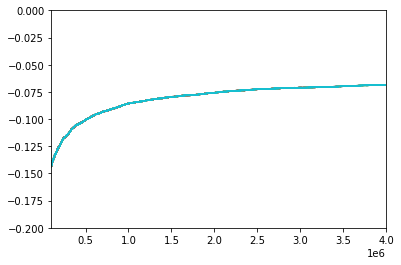

last_avg_reward -0.06843150000000842


TypeError: ignored

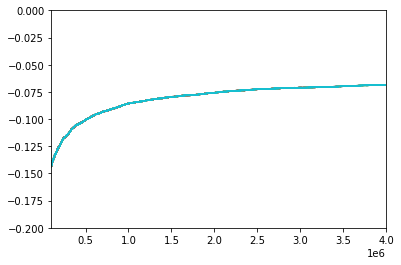

In [20]:
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

num_states = 3*7*32*11*2
num_actions = 3

def get_code_by_state(state):
    state_dims = [3, 7, 32 ,11, 2]
    size_state, card_state = get_composite_state(state[3][2])
    states = [size_state, card_state, state[0], state[1], (1 if state[2] else 0)]
    state_code = states[0]
    for i in range(1, len(states)):
        state_code = state_code * state_dims[i] + states[i]
    return state_code 

def get_state_by_code(code):
    state_dims = [3, 7, 32 ,11, 2]
    result = []
    for i in range(len(state_dims)-1, -1, -1):
        result.append(code%state_dims[i])
        code = int(code/state_dims[i])
        result.reverse()
    return tuple(result)


def conduct_experiment_double(learning_rate = 0.05, epsilon = 0.1, num_iterations = 100000, plot = False, debug = False):
    print(f'начинаем эксперимент, lr = {learning_rate} epsilon = {epsilon} num_iter = {num_iterations}')
    avg_rewards = []
    q_values = np.zeros((num_states, num_actions))
    states_counter = np.zeros((num_states, num_actions))
    for _ in range(num_iterations):
        state = env.reset()    
        if debug: print("New Game")
        state_code = get_code_by_state(state)
        if debug: print(state, "->", state_code)

        done = False

        while not done:
            action = egreedy_policy(q_values, state_code, epsilon)
            if debug: print("action", action)

            next_state, reward, done, index = env.step_new(action)

            next_state_code = get_code_by_state(next_state)

            if debug: print("next_state", next_state, reward, done, some, next_state_code, q_values[next_state_code][:])
            if debug: print("old value", q_values[state_code][:], reward, np.max(q_values[next_state_code]))            

            q_values[state_code][action] += learning_rate * (reward + np.max(q_values[next_state_code][:] if not done else 0) - q_values[state_code][action])
            states_counter[state_code][action] += 1

            if debug: print("new value", q_values[state_code][:])

            state_code = next_state_code
            if done == True:
                if len(avg_rewards) == 0:
                    avg_rewards.append(reward)
                else:
                    avg_rewards.append((avg_rewards[-1] * len(avg_rewards) + reward)/(len(avg_rewards)+1))

        if len(avg_rewards)%100000 == 0 and plot:
            pl.plot(avg_rewards)
            pl.xlim(100000, num_iterations)
            pl.ylim(-0.2,0)
            display.clear_output(wait=True)
            display.display(pl.gcf())
    print(f'last_avg_reward {avg_rewards[-1]}')
    return avg_rewards, states_counter, q_values


debug = False
env = BlackjackEnv_real(debug)
env.init_deck()
avg_rewards, states_counter, q_values = conduct_experiment_double(learning_rate = 0.02, epsilon = 0.02, num_iterations = 4000000, debug = debug, plot = True)



In [21]:
def get_state_by_code(code):
    state_dims = [3, 7, 32 ,11, 2]
    result = []
    for i in range(len(state_dims)-1, -1, -1):
        result.append(code%state_dims[i])
        code = int(code/state_dims[i])
        result.reverse()
    return tuple(result)

for i in range(num_states):
    if np.max(states_counter[i][:]) > 0:
        print(get_state_by_code(i), " assessment ", q_values[i][:], states_counter[i], np.argmax(q_values[i]))

(0, 4, 0, 1, 0)  assessment  [-0.02       -0.00524709 -0.04      ] [1. 5. 1.] 1
(0, 4, 0, 2, 0)  assessment  [-2.00000000e-02 -8.01884244e-05 -8.00000000e-04] [1. 1. 2.] 1
(0, 4, 0, 3, 0)  assessment  [-0.02263626 -0.00326576 -0.04      ] [7. 1. 1.] 1
(0, 4, 0, 4, 0)  assessment  [-0.02      -0.0058915 -0.04     ] [ 1. 14.  1.] 1
(0, 4, 0, 5, 0)  assessment  [-0.02       -0.01031363 -0.04      ] [1. 9. 1.] 1
(0, 4, 0, 6, 0)  assessment  [-0.00078416 -0.00130079 -0.04      ] [4. 5. 1.] 0
(0, 4, 0, 7, 0)  assessment  [-0.02        0.00205131  0.        ] [1. 7. 0.] 1
(0, 4, 0, 8, 0)  assessment  [-2.0000e-02 -8.0000e-06  3.7616e-02] [1. 1. 3.] 2
(0, 4, 0, 9, 0)  assessment  [-0.020392   -0.00067347 -0.04      ] [3. 1. 1.] 1
(0, 4, 0, 10, 0)  assessment  [-0.02       -0.014647   -0.04889027] [1. 6. 9.] 1
(0, 5, 0, 1, 0)  assessment  [-0.02       -0.00452441 -0.04      ] [1. 9. 1.] 1
(0, 5, 0, 2, 0)  assessment  [-0.02       -0.01847705 -0.04      ] [ 1. 16.  1.] 1
(0, 5, 0, 3, 0)  assessm

Существенного выигрыша не получилось, либо книга не очень либо программист я фиговый. В обоих случаях книгу смысла нет покупать.

# Задание 4

Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.

Начнем с оценки карт дилера, он может закончить с очками от 17 до 26, для каждого потенциального состояния посчитаем вероятности, очков с которыми он закончит 